In [9]:
import pandas as pd
from transformers import BlipProcessor, BlipForConditionalGeneration, TrainingArguments, Trainer, DataCollatorForSeq2Seq
import torch
from PIL import Image
import os
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt


In [10]:
# Leer el CSV
csv_path = "../train/data/output/divide_images_train/finetuning.csv"
df = pd.read_csv(csv_path)

# Cargar el procesador y el modelo
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

# Función para cargar y procesar imágenes
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return image

# Preparar datos de entrenamiento
train_data = []
for _, row in df.iterrows():
    image_path = row['image_dir']
    description = str(row['description'])  # Asegurarse de que la descripción sea una cadena
    if os.path.exists(image_path):
        image = load_image(image_path)
        inputs = processor(images=image, text=description, return_tensors="pt")
        pixel_values = inputs.pixel_values.squeeze()
        input_ids = inputs.input_ids.squeeze()
        attention_mask = inputs.attention_mask.squeeze()
        train_data.append((pixel_values, input_ids, attention_mask, input_ids))

# Función para crear un DataLoader

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixel_values, input_ids, attention_mask, labels = self.data[idx]
        return {'pixel_values': pixel_values, 'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

train_dataset = CustomDataset(train_data)


In [11]:
# Definir una función de colación personalizada
def custom_collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    input_ids = torch.nn.utils.rnn.pad_sequence([item['input_ids'] for item in batch], batch_first=True, padding_value=processor.tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence([item['attention_mask'] for item in batch], batch_first=True, padding_value=0)
    labels = torch.nn.utils.rnn.pad_sequence([item['labels'] for item in batch], batch_first=True, padding_value=-100)
    return {'pixel_values': pixel_values, 'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

# Configurar argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    save_steps=10_000,
    save_total_limit=2,
)

# Data collator
data_collator = DataCollatorForSeq2Seq(processor.tokenizer, model=model)

# Definir la función de entrenamiento
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=custom_collate_fn,  # Usar la función de colación personalizada
)

'''# Entrenar el modelo
trainer.train()

# Guardar el modelo afinado
model.save_pretrained("./results")
processor.save_pretrained("./results")'''

'# Entrenar el modelo\ntrainer.train()\n\n# Guardar el modelo afinado\nmodel.save_pretrained("./results")\nprocessor.save_pretrained("./results")'

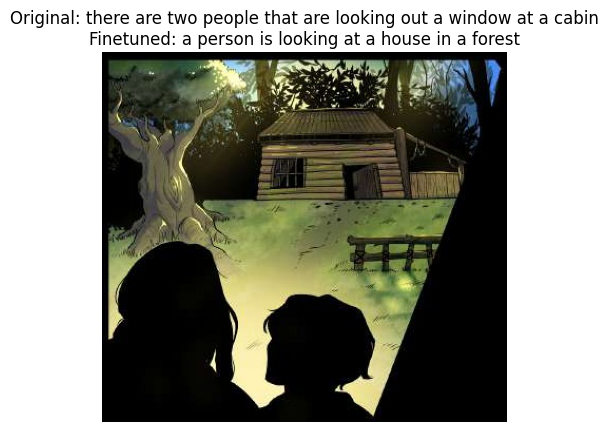

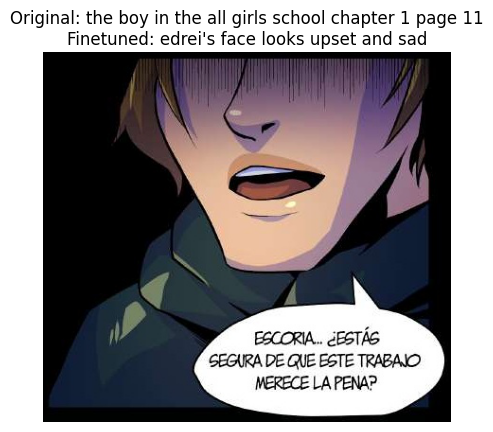

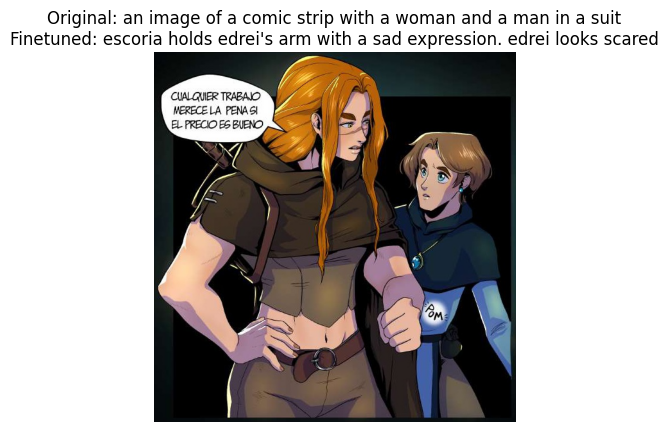

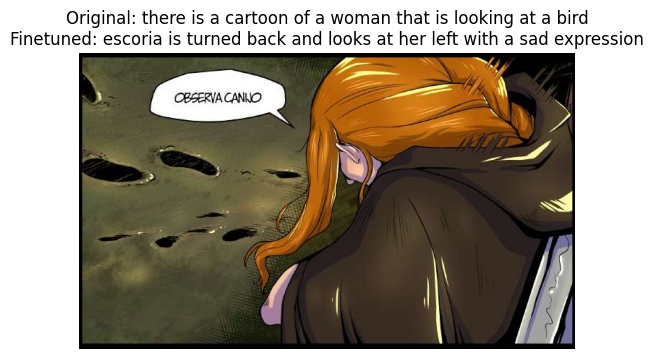

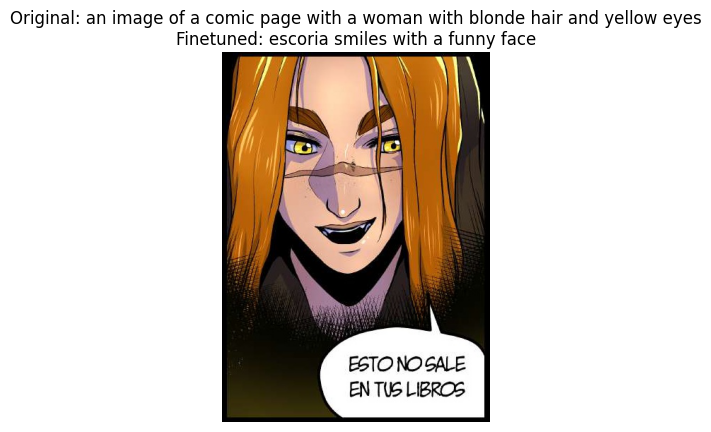

In [13]:
# Configurar el dispositivo (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el modelo afinado y moverlo al dispositivo
finetuned_model = BlipForConditionalGeneration.from_pretrained("./results").to(device)
finetuned_processor = BlipProcessor.from_pretrained("./results")

# Mover el modelo original al dispositivo
model.to(device)

# Obtener la lista de nombres de archivo en el directorio de imágenes de test
image_dir = '../data/output/divide_images_test/Chapter01/page2_img'
image_files = os.listdir(image_dir)

# Función para cargar y preprocesar una imagen
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    return inputs, image

# Bucle para describir cada imagen en el directorio usando ambos modelos
for image_file in image_files:
    # Construir la ruta completa de la imagen
    image_path = os.path.join(image_dir, image_file)
    
    # Procesar la imagen
    inputs, image = load_and_preprocess_image(image_path)
    
    # Mover los datos al dispositivo
    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}
    
    # Generar descripción con el modelo original
    original_outputs = model.generate(
        **inputs,
        max_length=100,
        num_beams=5,
        length_penalty=2.0,
        early_stopping=True
    )
    original_caption = processor.decode(original_outputs[0], skip_special_tokens=True)
    
    # Generar descripción con el modelo afinado
    finetuned_outputs = finetuned_model.generate(
        **inputs,
        max_length=100,
        num_beams=5,
        length_penalty=2.0,
        early_stopping=True
    )
    finetuned_caption = finetuned_processor.decode(finetuned_outputs[0], skip_special_tokens=True)
    
    # Imprimir las descripciones y mostrar la imagen
    plt.imshow(image)
    plt.title(f"Original: {original_caption}\nFinetuned: {finetuned_caption}")
    plt.axis('off')
    plt.show()